<a href="https://colab.research.google.com/github/realyou0312/DACON_CreditAI/blob/main/0524_Catboost_paramX_fold15_Last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Colab mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 패키지 설치

In [ ]:
!pip install catboost
!pip install category_encoders

## 라이브러리 구성

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool


## 데이터 불러오기

In [ ]:
path = '/content/drive/MyDrive/DACON_Credit/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

## 분석에 불필요한 index과 모든 값이 1로 동일한 FLAG_MOBIL 삭제

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

## Null값 대체

In [ ]:
train.fillna('NaN', inplace=True) 
test.fillna('NaN', inplace=True)

### DAYS_EMPLOYED 가 양수인 데이터는 현재 무직자로 판단, 0 처리

In [ ]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

## train['family_size'] > 8 인 데이터는 test에 없기 때문에 이상치로 판단 후 제거

In [ ]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

### 음수값 -> 양수 변환

In [ ]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

### Feature Engineering
ref) rollcake님 글 https://dacon.io/competitions/official/235713/codeshare/2526?page=1&dtype=recent

In [ ]:
for df in [train,test]:
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

    df['income_mean'] = df['income_total'] / df['family_size']
    
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)


### 중복 될 수 있는 컬럼 삭제

In [ ]:
cols = [

    'child_num',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',

]

train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

### Numeric, Category 컬럼 분류

In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))


Number of Numerical features:  18
Number of Categorical features:  9


In [ ]:
numerical_feats

['income_total',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 'before_EMPLOYED',
 'income_total_befofeEMP_ratio',
 'Age',
 'DAYS_BIRTH_m',
 'DAYS_BIRTH_w',
 'before_EMPLOYED_m',
 'before_EMPLOYED_w',
 'EMPLOYED',
 'DAYS_EMPLOYED_m',
 'DAYS_EMPLOYED_w',
 'ability',
 'income_mean']

In [ ]:
categorical_feats

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'ID']

## 숫자가 큰 income_total은 로그변환 처리

In [ ]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

## 카테고리 컬럼은 Credit에 따라 인코딩 -> OrdinalEncoder 이용

In [ ]:
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
train

,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,work_phone,phone,email,occyp_type,family_size,begin_month,credit,before_EMPLOYED,income_total_befofeEMP_ratio,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,before_EMPLOYED_m,before_EMPLOYED_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w,ability,income_mean,ID
0,1,1,1,12.218505,1,1,1,1,0,0,0,1,2.0,6.0,1.0,9190,22.034820,38,7.0,1.0,6.0,0.0,12,0.0,0.0,10.882416,101250.0,1
1,1,1,2,12.419174,1,2,2,2,0,0,1,2,3.0,5.0,1.0,9840,25.152439,31,7.0,1.0,4.0,1.0,4,3.0,0.0,19.156347,82500.0,2
2,2,2,2,13.017007,2,1,1,2,0,1,0,3,2.0,22.0,2.0,14653,30.710435,52,0.0,2.0,8.0,1.0,12,3.0,1.0,19.131840,225000.0,3
3,1,1,2,12.218505,1,2,1,2,0,1,0,4,2.0,37.0,0.0,12996,15.581717,41,10.0,3.0,1.0,0.0,5,9.0,2.0,11.786962,101250.0,4
4,1,2,2,11.967193,3,1,1,2,0,0,0,3,2.0,26.0,2.0,12932,12.179091,41,9.0,0.0,11.0,3.0,5,10.0,0.0,9.187959,78750.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26446,1,1,1,12.323865,3,2,1,2,0,0,0,6,4.0,2.0,1.0,10095,22.288262,33,6.0,1.0,0.0,2.0,5,6.0,3.0,15.999431,56250.0,3301
26447,1,1,2,12.100723,2,1,3,2,0,0,0,1,2.0,47.0,2.0,12816,14.044944,41,5.0,0.0,7.0,2.0,6,10.0,1.0,10.131712,90000.0,8753
26448,1,2,1,12.586227,2,2,2,3,0,0,0,6,2.0,25.0,2.0,8067,36.258832,27,0.0,0.0,4.0,0.0,5,7.0,3.0,24.179549,146250.0,8754
26449,2,1,2,12.049431,2,3,4,2,0,0,0,2,1.0,59.0,2.0,10038,17.035266,27,2.0,1.0,10.0,2.0,0,3.0,3.0,16.679672,171000.0,8755


## Kmeans 클러스터링 구성

In [ ]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

## 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화

In [ ]:
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])


## Modeling - catboost
 - parameter를 두는 것 보다 두지 않는 것이 logloss가 낮았음

In [ ]:
n_est = 2000
seed = 42
n_fold = 17
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))


cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = [
            'income_type',
            'edu_type',
            'family_type',
            'house_type',
            'occyp_type',
            'ID',
]
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data,
            eval_set=valid_data,
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=100,)
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')



----------------- Fold 0 -----------------

Learning rate set to 0.115146
0:	learn: 1.0346914	test: 1.0335236	best: 1.0335236 (0)	total: 54.5ms	remaining: 54.5s
100:	learn: 0.7040337	test: 0.6388958	best: 0.6388958 (100)	total: 8.96s	remaining: 1m 19s
200:	learn: 0.6838620	test: 0.6379441	best: 0.6377030 (180)	total: 19s	remaining: 1m 15s
300:	learn: 0.6665773	test: 0.6384742	best: 0.6373555 (216)	total: 28.9s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6373555421
bestIteration = 216

Shrink model to first 217 iterations.
CV Log Loss Score: 0.637356

----------------- Fold 1 -----------------

Learning rate set to 0.115146
0:	learn: 1.0345431	test: 1.0344755	best: 1.0344755 (0)	total: 36.9ms	remaining: 36.9s
100:	learn: 0.7048853	test: 0.6733899	best: 0.6733093 (97)	total: 8.68s	remaining: 1m 17s
200:	learn: 0.6861475	test: 0.6722208	best: 0.6714599 (156)	total: 18.6s	remaining: 1m 13s
300:	learn: 0.6670645	test: 0.6711567	best: 0.6710789 (297

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

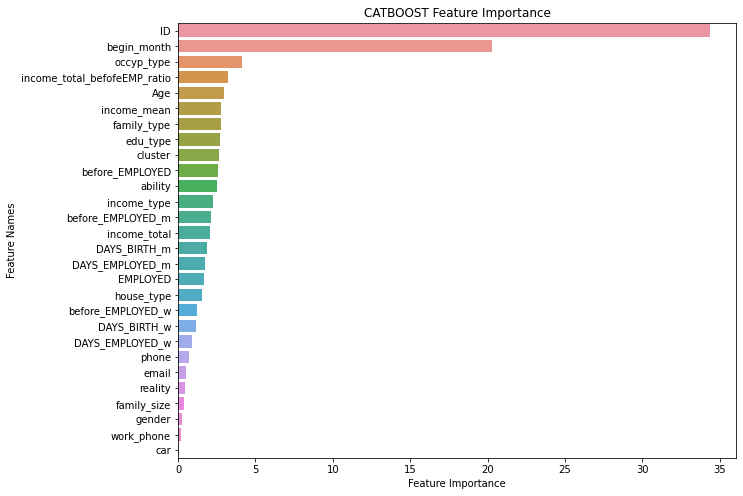

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

## submission 파일 불러오기

In [ ]:
sub = pd.read_csv(path + 'sample_submission.csv')
sub.iloc[:, 1:] = cat_pred_test

In [ ]:
sub

,index,0,1,2
0,26457,0.115007,0.173187,0.711806
1,26458,0.338757,0.209268,0.451975
2,26459,0.036046,0.079928,0.884026
3,26460,0.054953,0.081003,0.864043
4,26461,0.083036,0.233750,0.683214
...,...,...,...,...
9995,36452,0.072545,0.223114,0.704341
9996,36453,0.326732,0.173392,0.499876
9997,36454,0.048996,0.118619,0.832385
9998,36455,0.144859,0.310712,0.544429


## submission 파일 저장

In [ ]:
sub.to_csv('submission0523_Last.csv', index=False)